In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
from torchvision.transforms.functional import to_tensor
from torch.amp import autocast, GradScaler

import os
import numpy as np
import subprocess
from PIL import Image
import shutil

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def read_pickle(path) -> torch.tensor:
    temp = torch.load(path)
    return temp['video'], temp['label']

def get_all_file_paths(path) -> list:
    path_list = []
    for top, dirs, files in os.walk(path):
        for nm in files:
            path_list.append(os.path.join(top, nm))
    return path_list

In [4]:
def show_sequence(sequence, NUM_FRAMES):
    columns = 4
    rows = (NUM_FRAMES + 1) // (columns)
    fig = plt.figure(figsize=(32, (16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        frames = sequence[j].permute(1,2,0).numpy()
        frames = frames/ frames.max()
        plt.imshow(frames)

    plt.show()

In [5]:
def save_checkpoint(state, filename="checkpoint.pth"):
    """Save model and optimizer state to a file."""
    torch.save(state, filename)

def load_checkpoint(filename="checkpoint.pth"):
    """Load model and optimizer state from a file."""
    checkpoint = torch.load(filename)
    return checkpoint

In [6]:
# Paths to your pickle files - 
# train_data :
train_paths = get_all_file_paths('/kaggle/input/include-interpolated-cv/ISL_pickle/Train_data')
# test data :
test_paths = get_all_file_paths('/kaggle/input/include-interpolated-cv/ISL_pickle/Test_data')

In [ ]:
# showing one video
path_list = train_paths
for path in path_list:
    X,y = read_pickle(path=path)
    break

In [8]:
temp = X.to(torch.float32)

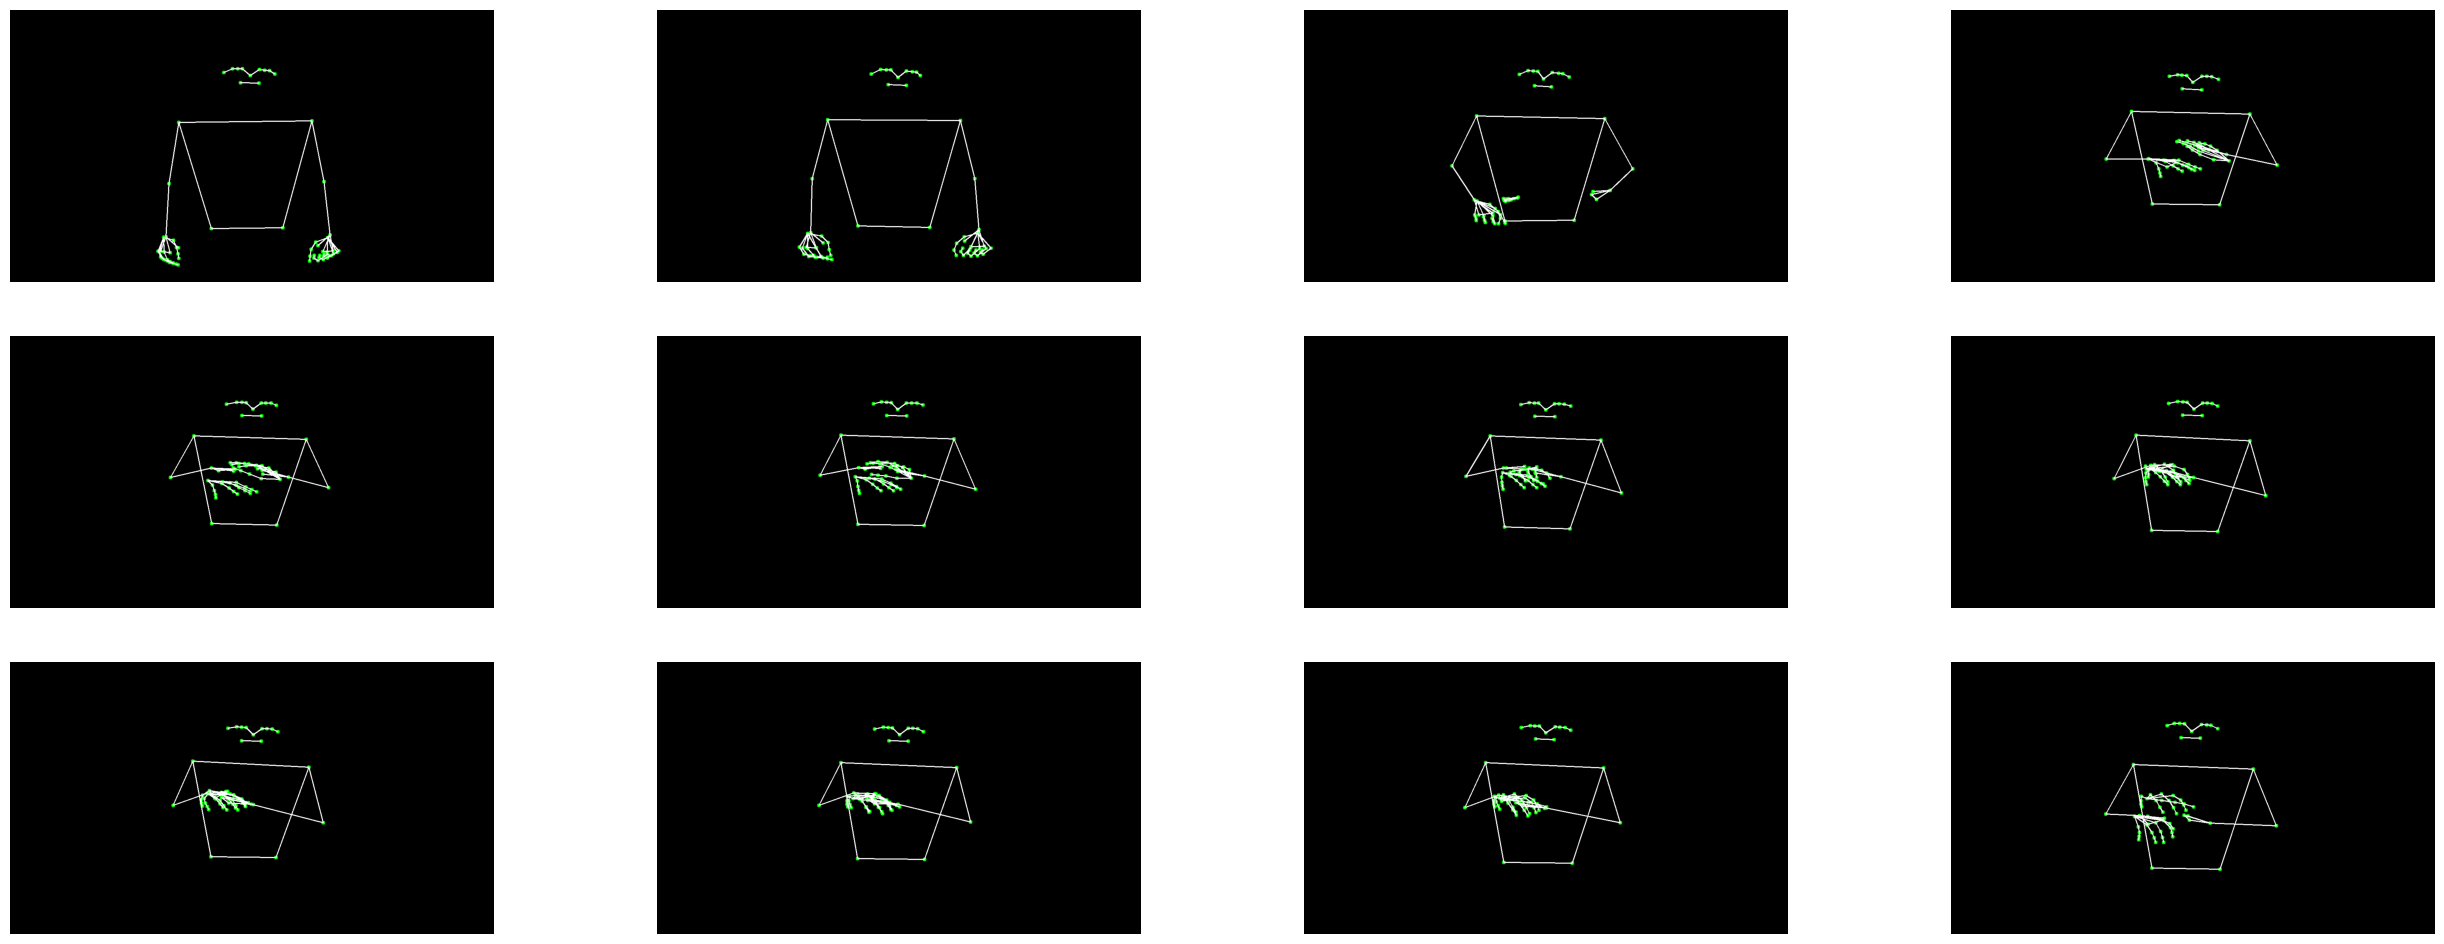

In [9]:
show_sequence(temp[0],12)

In [10]:
# Function to save processed data
def pickle_data(X, y, n, path):
    tensor_data = {
        'video': X.to(torch.float16),  # Convert to half-precision for smaller storage
        'label': y
    }
    os.makedirs(path, exist_ok=True)  # Ensure the save directory exists
    torch.save(tensor_data, os.path.join(path, f'tensor_{n}.pt'))

In [11]:
preprocess_frame = transforms.Compose([
    transforms.RandomCrop((680,1208)),
    transforms.CenterCrop((680,680)),
    transforms.Resize((300,300)),
    transforms.RandomRotation((-5,5))
])

In [12]:
# Function to preprocess video tensors
def apply_transforms(tensor: torch.Tensor) -> torch.Tensor:
    # Reshape to process individual frames
    batch_size, num_frames, channels, height, width = tensor.shape
    tensor = tensor.view(-1, channels, height, width)  # Flatten to 4D: [batch_size*num_frames, 3, H, W]
    processed_frames = torch.stack([preprocess_frame(frame) for frame in tensor])
    return processed_frames.view(batch_size, num_frames, channels, *processed_frames.shape[-2:])

In [15]:
# Function to load, resize, and save tensors
def resize_tensors(paths, path_to_save):
    for n, path in enumerate(paths):
        # Load tensor from disk
        video , label = read_pickle(path)
        video = video.to(torch.float32).to(device)
        
        video = apply_transforms(video)
        
        # Save processed tensor
        pickle_data(video, label, n, path_to_save)

In [ ]:
resize_tensors(train_paths,"/kaggle/working/include-interpolated-cv-300p-double-madness/ISL_pickle/Train_data")
resize_tensors(test_paths,"/kaggle/working/include-interpolated-cv-300p-double-madness/ISL_pickle/Test_data")

In [ ]:
# Use preload tensors notebook or use pathlists notebook for larger datasets.